In [2]:
import pandas as pd
from pathlib import Path


def select_lrps(
    roads_file='../data/_roads3.csv',
    roads=('N1',),
    start_lrp='LRPS',
    end_lrp='LRP235b',
    end_name='The chittagong city area starts from Alongka cinema Hall',
):
    """
    Select LRPs from certain road(s) in _roads3.csv, from a start LRP
    to an end LRP (inclusive).

    Parameters
    ----------
    roads_file : str or Path
        Path to the roads CSV file.
    roads : tuple of str
        Road identifiers to filter on (default: only 'N1').
    start_lrp : str
        The first LRP to include (default: 'LRPS').
    end_lrp : str
        The last LRP to include (default: 'LRP235b').
    end_name : str or None
        If provided, also match the 'name' column to disambiguate
        duplicate LRP codes across roads.

    Returns
    -------
    pd.DataFrame
        Subset of rows from start_lrp to end_lrp for the selected road(s).
    """
    df = pd.read_csv(roads_file)
    segments = []

    for road in roads:
        road_df = df[df['road'] == road].reset_index(drop=True)
        if road_df.empty:
            print(f"Warning: road '{road}' not found in data.")
            continue

        # Locate start LRP
        start_mask = road_df['lrp'] == start_lrp
        if not start_mask.any():
            raise ValueError(f"Start LRP '{start_lrp}' not found on road '{road}'.")
        start_idx = road_df.index[start_mask][0]

        # Locate end LRP (optionally filtered by name)
        end_mask = road_df['lrp'] == end_lrp
        if end_name is not None:
            end_mask = end_mask & (road_df['name'] == end_name)
        if not end_mask.any():
            raise ValueError(
                f"End LRP '{end_lrp}' (name='{end_name}') not found on road '{road}'."
            )
        end_idx = road_df.index[end_mask][0]

        if end_idx < start_idx:
            raise ValueError(
                f"End LRP '{end_lrp}' appears before start LRP '{start_lrp}' on road '{road}'."
            )

        segments.append(road_df.loc[start_idx:end_idx])

    if not segments:
        return pd.DataFrame(columns=df.columns)

    return pd.concat(segments, ignore_index=True)


# --- Run the selection ---
n1_segment = select_lrps()
print(f"Selected {len(n1_segment)} LRPs from road N1 (LRPS → LRP235b)")
n1_segment

Selected 565 LRPs from road N1 (LRPS → LRP235b)


,road,chainage,lrp,lat,lon,gap,type,name
0,N1,0.000,LRPS,23.706028,90.443333,NaN,Others,Start of Road after Jatrabari Flyover infront...
1,N1,0.814,LRPSa,23.702917,90.450417,NaN,Culvert,Box Culvert
2,N1,0.822,LRPSb,23.702778,90.450472,NaN,CrossRoad,Intersection with Z1101
3,N1,1.000,LRP001,23.702139,90.451972,NaN,KmPost,Km post missing
4,N1,2.000,LRP002,23.697889,90.460583,NaN,KmPost,Km post missing
...,...,...,...,...,...,...,...,...
560,N1,231.442,LRP234a,22.376472,91.770416,BS,Bridge,Bridge start
561,N1,231.461,LRP234b,22.376225,91.770543,BE,Bridge,Bridge end
562,N1,232.006,LRP235,22.369166,91.774194,NaN,KmPost,Km post missing
563,N1,232.561,LRP235a,22.369138,91.777666,NaN,Others,End of Bituminous Road


In [3]:
def get_bridges_lrp_and_fix_double(
    bmms_file='../data/BMMS_overview.xlsx',
    roads=('N1',),
):
    """
    Load bridge records from BMMS_overview.xlsx for the chosen roads and
    remove duplicate bridge entries that share the same chainage on a road.

    For each road the function:
      1. Filters the BMMS data to only rows belonging to that road.
      2. Identifies groups of records that share the same chainage value.
      3. Where duplicates exist, prefers the **left** bridge (name
         containing '(L)') because Bangladesh uses left-hand traffic.
         If no left bridge is found in a duplicate group, keeps the
         last record as a fallback.
      4. After chainage-based dedup, drops any remaining right-side
         bridges (name containing '(R)') whose left counterpart may
         sit at a slightly different chainage.
      5. Concatenates the de-duplicated segments for all requested roads.

    Parameters
    ----------
    bmms_file : str or Path
        Path to the BMMS overview Excel file.
    roads : tuple of str
        Road identifiers to include (default: ('N1',)).

    Returns
    -------
    pd.DataFrame
        Bridge dataframe without duplicate chainage entries per road.
    """
    bmms = pd.read_excel(bmms_file)
    cleaned_segments = []

    for road in roads:
        road_df = bmms[bmms['road'] == road].copy()

        if road_df.empty:
            print(f"Warning: no records found for road '{road}' in BMMS data.")
            continue

        n_before = len(road_df)

        # ── Pass 1: chainage-based dedup (prefer left bridges) ──
        kept_rows = []
        for _, group in road_df.groupby('chainage'):
            if len(group) == 1:
                kept_rows.append(group.iloc[0])
            else:
                left_mask = group['name'].str.contains(
                    r'(?i)\(L\)', na=False
                )
                if left_mask.any():
                    kept_rows.append(group[left_mask].iloc[0])
                else:
                    kept_rows.append(group.iloc[-1])

        road_df = pd.DataFrame(kept_rows)
        n_after_dedup = len(road_df)

        # ── Pass 2: drop remaining right-side bridges '(R)' ──
        # Some (R) bridges sit at a slightly different chainage than
        # their (L) counterpart, so they survive pass 1. Since we
        # model left-hand traffic, all (R) entries are removed.
        right_mask = road_df['name'].str.contains(
            r'(?i)\(R\)', na=False
        )
        n_right = right_mask.sum()
        road_df = road_df[~right_mask].reset_index(drop=True)

        n_after = len(road_df)
        n_removed = n_before - n_after
        print(
            f"Road {road}: {n_before} bridge records → {n_after} unique "
            f"(removed {n_before - n_after_dedup} chainage duplicates, "
            f"{n_right} right-side bridges)"
        )

        cleaned_segments.append(road_df)

    if not cleaned_segments:
        return pd.DataFrame(columns=bmms.columns)

    return pd.concat(cleaned_segments, ignore_index=True)


# --- Run ---
bridges_n1 = get_bridges_lrp_and_fix_double()
print(f"\nResulting bridge dataframe: {bridges_n1.shape[0]} rows, {bridges_n1.shape[1]} columns")

# Verify no (R) bridges remain
r_check = bridges_n1[bridges_n1['name'].str.contains(r'(?i)\(R\)', na=False)]
print(f"Remaining (R) bridges: {len(r_check)}")

bridges_n1

Road N1: 787 bridge records → 625 unique (removed 159 chainage duplicates, 3 right-side bridges)

Resulting bridge dataframe: 625 rows, 20 columns
Remaining (R) bridges: 0


,road,km,type,LRPName,name,length,condition,structureNr,roadName,chainage,width,constructionYear,spans,zone,circle,division,sub-division,lat,lon,EstimatedLoc
0,N1,1.800,Box Culvert,LRP001a,.,11.3,A,117861,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,1.800,19.50,2005.0,2.0,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.698739,90.458861,interpolate
1,N1,4.925,Box Culvert,LRP004b,.,6.6,A,117862,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,4.925,35.40,2006.0,1.0,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.694664,90.487775,interpolate
2,N1,8.976,PC Girder Bridge,LRP008b,KANCHPUR PC GIRDER BRIDGE,397.0,C,101102,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,8.976,14.65,1986.0,8.0,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.705060,90.523214,interpolate
3,N1,10.543,Box Culvert,LRP010a,KATCHPUR BOX CULVERT,8.0,B,101106,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,10.543,21.70,1987.0,2.0,Dhaka,Dhaka,Narayanganj,Vitikandi,23.696400,90.535099,interpolate
4,N1,10.880,Box Culvert,LRP010b,NOYAPARA CULVERT,6.3,A,112531,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,10.880,12.20,1992.0,2.0,Dhaka,Dhaka,Narayanganj,Vitikandi,23.694391,90.537574,interpolate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,N1,458.213,RCC Girder Bridge,LRP454b,NAITOM PARA RCC GIDER BRIDGE,9.0,B,100896,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,458.213,7.30,1973.0,1.0,Chittagong,Chittagong,Cox's Bazar,Cox's Bazar - 2,20.892271,92.290984,interpolate
621,N1,458.799,RCC Girder Bridge,LRP455a,Eskahal Bridge,37.3,C,120597,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,458.799,NaN,NaN,NaN,Chittagong,Chittagong,Cox's Bazar,Cox's Bazar - 2,20.890158,92.295718,interpolate
622,N1,459.681,Box Culvert,LRP456a,BUS STAND TEKNAF BOX CULVERT,1.5,A,100891,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,459.681,10.30,1991.0,1.0,Chittagong,Chittagong,Cox's Bazar,Cox's Bazar - 2,20.884567,92.298716,interpolate
623,N1,459.866,Box Culvert,LRP456b,BUS STAND TEKNAF BOX CULVERT,1.5,C,100893,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,459.866,10.30,1989.0,1.0,Chittagong,Chittagong,Cox's Bazar,Cox's Bazar - 2,20.883070,92.298163,interpolate


In [4]:
import math
import numpy as np


# ── Helpers ───────────────────────────────────────────────────────

def haversine(lat1, lon1, lat2, lon2):
    """Great-circle distance between two lat/lon points in **meters**."""
    R = 6_371_000  # Earth radius in metres
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlam = math.radians(lon2 - lon1)
    a = (math.sin(dphi / 2) ** 2
         + math.cos(phi1) * math.cos(phi2) * math.sin(dlam / 2) ** 2)
    return R * 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))


def find_nearest_bmms_bridge(lat, lon, bridges_df):
    """Return (nearest_row, distance_m) from *bridges_df*."""
    min_dist = float('inf')
    nearest = None
    for _, row in bridges_df.iterrows():
        d = haversine(lat, lon, row['lat'], row['lon'])
        if d < min_dist:
            min_dist = d
            nearest = row
    return nearest, min_dist


# ── Function 1: combined_as_N1_road ──────────────────────────────

def combined_as_N1_road(road_df, bridge_df, roads=('N1',)):
    """
    Combine road-segment data (from _roads3.csv) and bridge data
    (from BMMS_overview.xlsx) into a simulation-ready dataframe.

    Processing rules per segment type
    ----------------------------------
    **Culvert**  – A link is placed for connectivity.  Then the BMMS
        database is searched for a bridge within 50 m; if found, a
        bridge entry is added with the BMMS attributes.  If not, only
        the link is kept (no bridge exists at this culvert).

    **Bridge** (gap = BS / BE) – Links are placed at the bridge-start
        and bridge-end points.  A bridge is placed between them using
        a single- or double-point location estimate (midpoint when
        both BS and BE are present).  The nearest BMMS record is found
        by looping over all candidates; if within 200 m its attributes
        are used, otherwise a dummy bridge with condition 'B' is placed.
        The distance between the bridge and its end link is set to 0 so
        that no distance is double-counted.

    **Others** – Checked for source (``LRPS``) or sink (``LRPE`` /
        last entry).  Source gets length 0; sink length is determined
        later by the distance function.  Other "Others" entries become
        links.

    **Default** (KmPost, CrossRoad, SideRoad, …) – Added as a link.

    Returns
    -------
    pd.DataFrame
        Columns: road, id, model_type, name, lat, lon, length, condition.
        Length is ``NaN`` for entries that still need distance computation.
    """
    entries = []
    id_bases = {f'N{n}': n * 1_000_000 for n in range(1, 9)}

    for road_name in roads:
        rd = road_df[road_df['road'] == road_name].reset_index(drop=True)
        br = bridge_df[bridge_df['road'] == road_name].reset_index(drop=True)
        if rd.empty:
            print(f"Warning: no segments for road '{road_name}'.")
            continue

        cid = id_bases.get(road_name, 1_000_000)
        link_n = bridge_n = 0

        # ---- internal helpers ----
        def _add(model_type, name, lat, lon, length, condition=''):
            nonlocal cid
            entries.append(dict(
                road=road_name, id=cid, model_type=model_type,
                name=name, lat=lat, lon=lon,
                length=length, condition=condition,
            ))
            cid += 1

        def _bmms_name(nearest_row, fallback):
            n = nearest_row['name'] if pd.notna(nearest_row['name']) else ''
            return n if n and n != '.' else fallback

        # ---- iterate through road segments ----
        i = 0
        while i < len(rd):
            s     = rd.iloc[i]
            stype = str(s['type']).strip()
            sgap  = str(s['gap']).strip() if pd.notna(s['gap']) else ''
            slrp  = str(s['lrp']).strip()

            # ═══ Others: source / sink / link ═══
            if stype == 'Others':
                if slrp == 'LRPS' or i == 0:
                    _add('source', 'source', s['lat'], s['lon'], 0)
                elif slrp == 'LRPE' or i == len(rd) - 1:
                    _add('sink', 'sink', s['lat'], s['lon'], np.nan)
                else:
                    link_n += 1
                    _add('link', f'link {link_n}', s['lat'], s['lon'], np.nan)
                i += 1

            # ═══ Culvert ═══
            elif stype == 'Culvert':
                link_n += 1
                _add('link', f'link {link_n}', s['lat'], s['lon'], np.nan)

                # search BMMS within 50 m
                nearest, dist = find_nearest_bmms_bridge(
                    s['lat'], s['lon'], br)
                if nearest is not None and dist <= 50:
                    bridge_n += 1
                    blen  = nearest['length'] if pd.notna(nearest['length']) else 0
                    bcond = nearest['condition'] if pd.notna(nearest['condition']) else 'B'
                    bname = _bmms_name(nearest, f'bridge {bridge_n}')
                    _add('bridge', bname, s['lat'], s['lon'], blen, bcond)
                i += 1

            # ═══ Bridge (BS / BE) ═══
            elif stype == 'Bridge':
                if sgap == 'BS':
                    bs_lat, bs_lon = s['lat'], s['lon']

                    # link at bridge start
                    link_n += 1
                    _add('link', f'link {link_n}', bs_lat, bs_lon, np.nan)

                    # look-ahead for the matching BE
                    be_lat = be_lon = None
                    if (i + 1 < len(rd)
                            and str(rd.iloc[i + 1]['gap']).strip() == 'BE'):
                        nxt = rd.iloc[i + 1]
                        be_lat, be_lon = nxt['lat'], nxt['lon']

                    # estimate bridge location (single or double point)
                    if be_lat is not None:
                        blat = (bs_lat + be_lat) / 2
                        blon = (bs_lon + be_lon) / 2
                    else:
                        blat, blon = bs_lat, bs_lon

                    # find nearest BMMS bridge by looping through all records
                    nearest, dist = find_nearest_bmms_bridge(blat, blon, br)
                    bridge_n += 1

                    if nearest is not None and dist <= 200:
                        blen  = nearest['length'] if pd.notna(nearest['length']) else 0
                        bcond = nearest['condition'] if pd.notna(nearest['condition']) else 'B'
                        bname = _bmms_name(nearest, s['name'])
                    else:
                        # dummy bridge – distance too large for confidence
                        blen  = 0
                        bcond = 'B'
                        bname = s['name']

                    _add('bridge', bname, blat, blon, blen, bcond)

                    # link at bridge end – distance set to 0 (no double-count)
                    if be_lat is not None:
                        link_n += 1
                        _add('link', f'link {link_n}', be_lat, be_lon, 0)
                        i += 2          # consumed BS + BE
                    else:
                        i += 1

                elif sgap == 'BE':
                    # orphan BE without a preceding BS → plain link
                    link_n += 1
                    _add('link', f'link {link_n}', s['lat'], s['lon'], np.nan)
                    i += 1

                else:
                    # bridge type without BS/BE gap → plain link
                    link_n += 1
                    _add('link', f'link {link_n}', s['lat'], s['lon'], np.nan)
                    i += 1

            # ═══ Default (KmPost, CrossRoad, SideRoad, …) → link ═══
            else:
                link_n += 1
                _add('link', f'link {link_n}', s['lat'], s['lon'], np.nan)
                i += 1

        print(f"Road {road_name}: {link_n} links, {bridge_n} bridges, "
              f"{cid - id_bases.get(road_name, 1_000_000)} total entries")

    return pd.DataFrame(entries)


# ── Function 2: calculate_distances ──────────────────────────────

def calculate_distances(df):
    """
    Iterate over all road segments and calculate the Haversine distance
    between consecutive segments for every entry whose length is still
    NaN (i.e. not yet determined).

    Pre-set lengths are left untouched:
      • source  → 0
      • bridge  → BMMS length
      • BE link → 0  (no double-counting with the bridge)

    Returns a copy of *df* with all lengths filled and cast to int.
    """
    df = df.copy()
    for i in range(len(df)):
        if pd.isna(df.iloc[i]['length']):
            if i == 0:
                df.at[df.index[i], 'length'] = 0
            else:
                prev = df.iloc[i - 1]
                d = haversine(prev['lat'], prev['lon'],
                              df.iloc[i]['lat'], df.iloc[i]['lon'])
                df.at[df.index[i], 'length'] = round(d)
    df['length'] = df['length'].round().astype(int)
    return df


# ── Execute ──────────────────────────────────────────────────────

print('Building combined road model …')
df_combined = combined_as_N1_road(n1_segment, bridges_n1)
print(f'  → {len(df_combined)} entries before distance calculation\n')

print('Calculating segment distances …')
df_road = calculate_distances(df_combined)
print(f'  → {len(df_road)} entries with distances filled\n')

# Save
save_path = '../data/df_road_file.csv'
df_road.to_csv(save_path, index=False)
print(f'Saved  {save_path}  ({df_road.shape[0]} rows × {df_road.shape[1]} cols)')
print(f'\nmodel_type breakdown:\n{df_road["model_type"].value_counts().to_string()}')
df_road

Building combined road model …
Road N1: 563 links, 82 bridges, 647 total entries
  → 647 entries before distance calculation

Calculating segment distances …
  → 647 entries with distances filled

Saved  ../data/df_road_file.csv  (647 rows × 8 cols)

model_type breakdown:
model_type
link      563
bridge     82
source      1
sink        1


,road,id,model_type,name,lat,lon,length,condition
0,N1,1000000,source,source,23.706028,90.443333,0,
1,N1,1000001,link,link 1,23.702917,90.450417,800,
2,N1,1000002,link,link 2,23.702778,90.450472,16,
3,N1,1000003,link,link 3,23.702139,90.451972,168,
4,N1,1000004,link,link 4,23.697889,90.460583,996,
...,...,...,...,...,...,...,...,...
642,N1,1000642,bridge,Bridge start,22.376349,91.770480,0,B
643,N1,1000643,link,link 561,22.376225,91.770543,0,
644,N1,1000644,link,link 562,22.369166,91.774194,870,
645,N1,1000645,link,link 563,22.369138,91.777666,357,


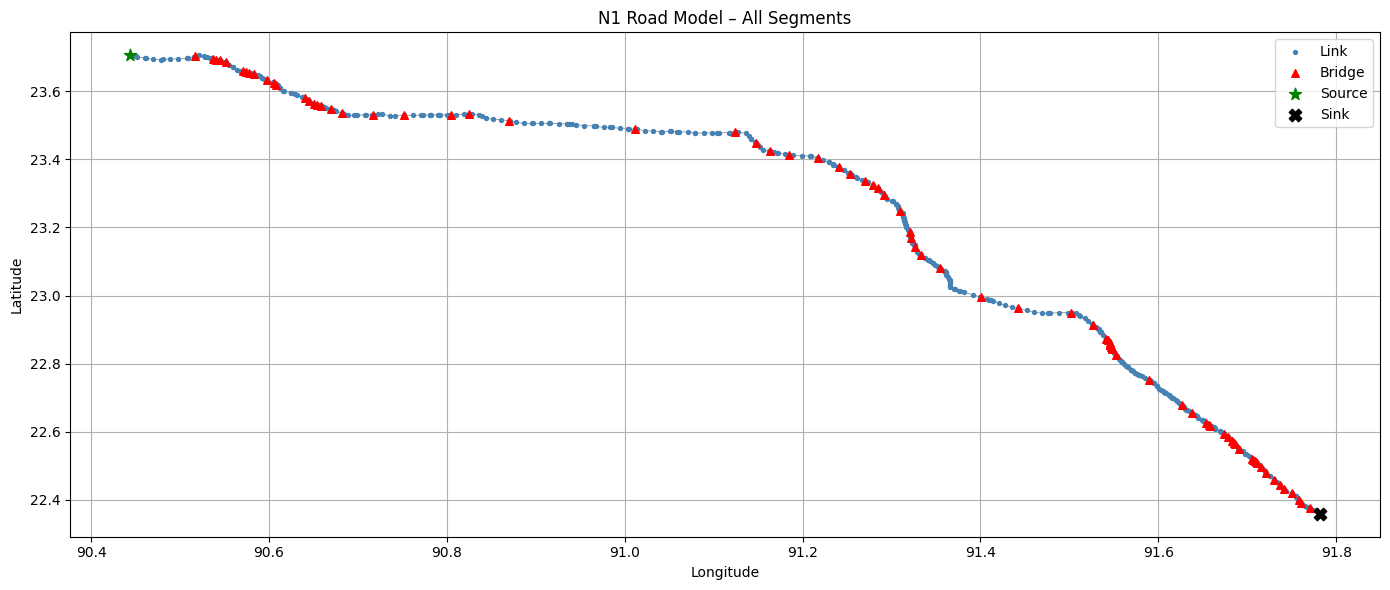

In [5]:
import matplotlib.pyplot as plt

csv_path = r"../data/df_road_file.csv"
df_csv = pd.read_csv(csv_path)

# Separate by model_type for colour-coded plotting
bridges = df_csv[df_csv['model_type'] == 'bridge']
links   = df_csv[df_csv['model_type'] == 'link']
source  = df_csv[df_csv['model_type'] == 'source']
sink    = df_csv[df_csv['model_type'] == 'sink']

plt.figure(figsize=(14, 6))
plt.plot(df_csv['lon'], df_csv['lat'], linewidth=0.5, color='grey', zorder=1)
plt.scatter(links['lon'], links['lat'], s=8, color='steelblue', label='Link', zorder=2)
plt.scatter(bridges['lon'], bridges['lat'], s=30, color='red', marker='^', label='Bridge', zorder=3)
plt.scatter(source['lon'], source['lat'], s=80, color='green', marker='*', label='Source', zorder=4)
plt.scatter(sink['lon'], sink['lat'], s=80, color='black', marker='X', label='Sink', zorder=4)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('N1 Road Model – All Segments')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()